# Tweets Preprocessing

In [6]:
!python -m pip install spacy==2.3.2 -q
!python -m spacy download pl_core_news_md  -q

     |████████████████████████████████| 9.9 MB 4.1 MB/s 
     |████████████████████████████████| 2.1 MB 44.3 MB/s 
     |████████████████████████████████| 79.9 MB 518 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')


In [2]:
import os
import tweepy as tw
import pandas as pd
import numpy as np
import time
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import re
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from wordcloud import WordCloud
import multiprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pobranie tweetów

## plik txt załączony - nie uruchamiamy ponownie

In [ ]:
api_key = 'XX'
api_key_secret = 'XX'
access_token = 'XX'
access_token_secret = 'XX'

In [ ]:
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
f =  open('/content/drive/MyDrive/ZUM projekt/pl_covid_tweets_clean.txt') 
f1 =f.readlines()

In [ ]:
df = pd.DataFrame(f1)
df = df[0].str.split(expand=True,)
df = df[0][1:]
df = pd.DataFrame(df)
df.columns = ['tweet_id']

In [ ]:
tweet_txt = []
sec = 0 
a = 0
b = 100
while sec < round(len(df)/100):
  try:
    tweets = api.statuses_lookup(list(df['tweet_id'][a:b]))
    for i in tweets:
      tweet_txt.append(i.text)
   
    if (sec % 100) == 0:
      with open('/content/drive/MyDrive/ZUM projekt/pl_covid_tweets.txt', 'w') as f:
        for item in tweet_txt:
          item = item.replace('\n', ' ')
          f.write("%s\n" % item)
      print("sequence number:", sec)
    sec+=1
    a = 100 * sec
    b = 100 + 100 * sec

  except BaseException as e:
          print('failed on_status,',str(e)) 
          time.sleep(5) 

####Wczytanie tweetów z pliku tekstowego

In [4]:
raw_data = pd.read_csv(f'/content/drive/MyDrive/ZUM projekt/pl_covid_tweets.txt', sep='delimiter', header = None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [5]:
raw_data.columns = ['tweet']
raw_data[:5]

,tweet
0,"Kiedy #coronavirus dotrze do Polski, napotka o..."
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...
2,A tymczasem w Wuhan odcięto od reszty świata o...
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am..."


## Czyszczenie i obróbka danych

In [6]:
nlp = spacy.load('pl_core_news_md')
lemma = WordNetLemmatizer()
nltk.download('wordnet')
stopwordlist = nlp.Defaults.stop_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
raw_data['tweet'].drop_duplicates(keep="first", inplace=True)

In [8]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    text = re.sub('[^a-zA-Z\']', ' ', text)
    text = re.sub('\t', '', text)
    text = re.sub('\S*@\S*\s?', ' ',text)
    text = emoji_pattern.sub(r'', text)
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    text = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist])
    text = [lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist]
    return text 

In [10]:
raw_data['clean_text'] = raw_data['tweet'].apply(clean_text)
raw_data.dropna(subset = ["clean_text"], inplace=True)
raw_data['cleaned_text'] = raw_data['clean_text'].apply(lambda x:' '.join(x))
raw_data.head()

,tweet,clean_text,cleaned_text
0,"Kiedy #coronavirus dotrze do Polski, napotka o...","[coronavirus, dotrze, polski, napotka, op, zna...",coronavirus dotrze polski napotka op znakomici...
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,"[kolejni, polacy, chc, wr, wuhan]",kolejni polacy chc wr wuhan
2,A tymczasem w Wuhan odcięto od reszty świata o...,"[tymczasem, wuhan, odci, reszty, wiata, obszar...",tymczasem wuhan odci reszty wiata obszar por w...
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,"[zdziwi, si, powiedz, listy, pojecha, chin, wu...",zdziwi si powiedz listy pojecha chin wuhan odw...
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...","[rp, polak, wr, wuhan, ambasadzie, rp, pekinie...",rp polak wr wuhan ambasadzie rp pekinie powo a...


## **Labeling**

2 klasy - pozytywna i negatywna


In [11]:
sent = [row for row in raw_data['clean_text']]
phrases = Phrases(sent, min_count=1, progress_per=500000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [12]:
w2v_model = Word2Vec(min_count=4,
                     window=5,
                     size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(sentences, progress_per= 500000)

In [13]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(45852883, 98996850)

In [14]:
w2v_model.save("/content/drive/MyDrive/ZUM projekt/word2vec.model")

In [15]:
word_vectors = Word2Vec.load("/content/drive/MyDrive/ZUM projekt/word2vec.model").wv

In [16]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))
positive_cluster_center = model.cluster_centers_[1]
negative_cluster_center = model.cluster_centers_[0]

In [17]:
words = pd.DataFrame(word_vectors.index2entity)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [18]:
words['cluster_value'] = [1 if i==1 else 0 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [19]:
words[words["cluster_value"]==1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
3564,eczno_ciowych,"[0.08156455, 0.0057711527, -0.87826437, 0.7308...",1,1,0.068745
3625,mediach_spo,"[0.67832965, -0.24479063, -0.9093826, 0.039651...",1,1,0.071756
4541,eczny,"[0.9698743, -1.0646765, -1.10294, 0.84433377, ...",1,1,0.073067
4483,dystans_spo,"[0.5608451, -0.3645783, -1.322178, 0.6733994, ...",1,1,0.073109
3766,dek,"[-0.14354123, 0.18081386, 0.52652854, -0.06948...",1,1,0.082480
...,...,...,...,...,...
81056,zyk_obcych,"[0.16164489, 0.046824005, 0.05773933, -0.00617...",1,1,3.093711
79867,idiotycznymi,"[0.13619573, -0.023086563, 0.021755671, -0.024...",1,1,3.094166
78264,berety,"[0.16011317, 0.029354291, 0.042498995, -0.0420...",1,1,3.174593
82156,posle,"[0.17905961, 0.011911566, 0.042256333, -0.0420...",1,1,3.196658


In [20]:
words[words["cluster_value"]==0].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
5413,stanu_wyj,"[0.8830807, 0.42907318, 0.20298204, 0.24619886...",0,0,0.073580
4314,owej,"[0.97819036, 0.14290985, 0.39115056, 1.5042621...",0,0,0.074731
2968,lekarzy_piel,"[0.8650463, -0.014645286, -0.29739416, -0.2646...",0,0,0.075869
5271,kszo,"[-0.21441852, 1.3825141, -0.40254623, 0.971067...",0,0,0.077877
2340,stan_wyj,"[-1.1954869, 0.50614965, 1.1331028, 0.94011545...",0,0,0.078620
...,...,...,...,...,...
67356,zakresie_programu,"[0.15728216, 0.06924231, -0.07531277, 0.010772...",0,0,2.442350
76977,linie_wolfsburg,"[0.14938891, 0.06257749, -0.014810319, 0.01611...",0,0,2.475160
72766,wytypowane_szpitale,"[0.12724137, 0.059392218, -0.02487266, 0.03252...",0,0,2.635051
63620,stworzy_bomb,"[0.14885214, 0.10209131, -0.041647106, 0.06638...",0,0,3.168902


In [21]:
positive = ['dobry','miły','niesamowity','śmieszny','kochany','słodki']
negative= ['głupi','szalony','niesympatyczny','zły','straszny', 'absurdalny' 'durny']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"] = 0

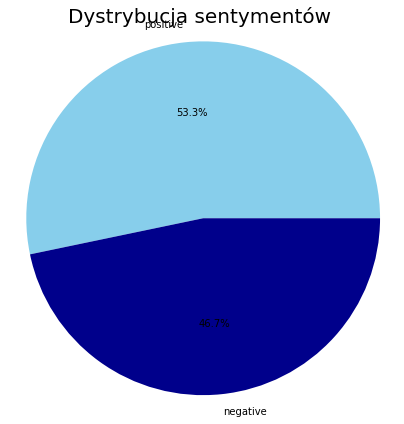

,index,sentiments
0,positive,45154
1,negative,39607


In [22]:
emotion = {1: "positive",
           0: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["skyblue","darkblue"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

In [23]:
from math import nan
def get_sentiments(x, sent_dict):
    total = 0
    count = 0
    test = x["clean_text"]
    for t in test:
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1 
    if count == 0:
     avg = 0 
    else:
      avg = total/count

    #print(avg)
    sentiment = 0 if avg < 0.5 else 1
    return sentiment

In [24]:
words_dict = dict(zip(words.words, words.cluster_value))

In [25]:
raw_data["sentiment"] = raw_data.apply(get_sentiments, args=(words_dict,), axis=1)

In [26]:
raw_data["sentiment"].value_counts()

1    287637
0    196023
Name: sentiment, dtype: int64

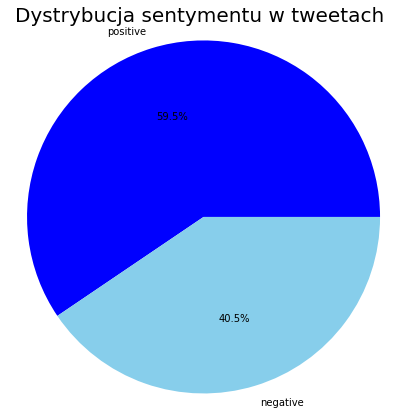

,index,sentiments_val
0,positive,287637
1,negative,196023


In [30]:
emotion = {1: "positive",
           0: "negative"}

raw_data["sentiments_val"] = raw_data["sentiment"].map(emotion)
df_pie = raw_data["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["blue","skyblue"]
plt.pie(df_pie["sentiments_val"],labels= df_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Dystrybucja sentymentu w tweetach ", fontsize=20)
plt.show()
df_pie

In [31]:
raw_data.head()

,tweet,clean_text,cleaned_text,sentiment,sentiments_val
0,"Kiedy #coronavirus dotrze do Polski, napotka o...","[coronavirus, dotrze, polski, napotka, op, zna...",coronavirus dotrze polski napotka op znakomici...,1,positive
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,"[kolejni, polacy, chc, wr, wuhan]",kolejni polacy chc wr wuhan,1,positive
2,A tymczasem w Wuhan odcięto od reszty świata o...,"[tymczasem, wuhan, odci, reszty, wiata, obszar...",tymczasem wuhan odci reszty wiata obszar por w...,0,negative
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,"[zdziwi, si, powiedz, listy, pojecha, chin, wu...",zdziwi si powiedz listy pojecha chin wuhan odw...,1,positive
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...","[rp, polak, wr, wuhan, ambasadzie, rp, pekinie...",rp polak wr wuhan ambasadzie rp pekinie powo a...,1,positive


In [32]:
raw_data.to_csv( "/content/drive/MyDrive/ZUM projekt/clean_data.csv", index=False, encoding='utf-8-sig')